# 06 Modeling

In [60]:
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import plotly.graph_objects as go
import plotly.express as px
from pandas import Series
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
%matplotlib inline

In [61]:
print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone3/Data') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone3/Data
/Users/liuyang/Desktop/Springboard_Capstone3/Data


In [62]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/Users/liuyang/Desktop/Springboard_Capstone3/notebook')
# os.chdir('/Users/liuyang/Desktop/Springboard_Capstone3/notebook') 
import eda

In [63]:
df = pd.read_csv('train.csv')
newstoredata = pd.read_csv('combined_data.csv')

In [64]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [65]:
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')

In [66]:
df = df.sort_values(['Date', 'Store'], ascending=True)

In [73]:
storeid=186
storedailydata=df.loc[df.Store==storeid]
storeweeklysales = storedailydata.set_index('Date').resample('w').Sales.sum()
print(f'The shape of storeweeklysales is: {storeweeklysales.shape}')

The shape of storeweeklysales is: (135,)


In [74]:
from eda import data_process, Sales_EDA, sumby, individual_store, combined_storedata, combined_store_EDA

In [75]:
# Get store sales performance report
storeanalyze= individual_store(df, 'Date', storeid)

storeanalyze.store_report(newstoredata)

,Detail
Storeid,186
Store Type,A
Assortment,A
Open Days,622
Closed Days,136
Total Sales,2.35355e+06
Share in All Store (%),0.04
Share in A Type (%),0.539
Share in A Assortment (%),0.663
Ranking in All Store,1107


In [76]:
len(storeweeklysales.loc['2015-01-04':][-9:-1])

8

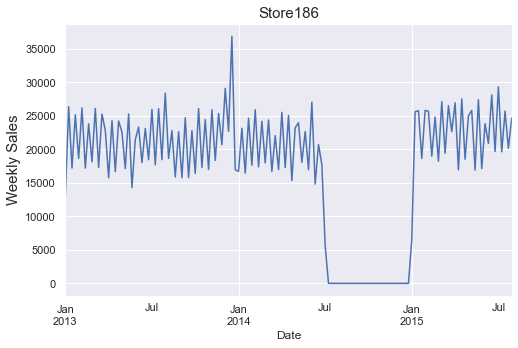

In [77]:
plt.rcParams['figure.figsize'] = (8, 5)
storeweeklysales.plot()
plt.title(f'Store{storeid}', fontsize=15)
plt.ylabel('Weekly Sales', fontsize=15)
plt.show()

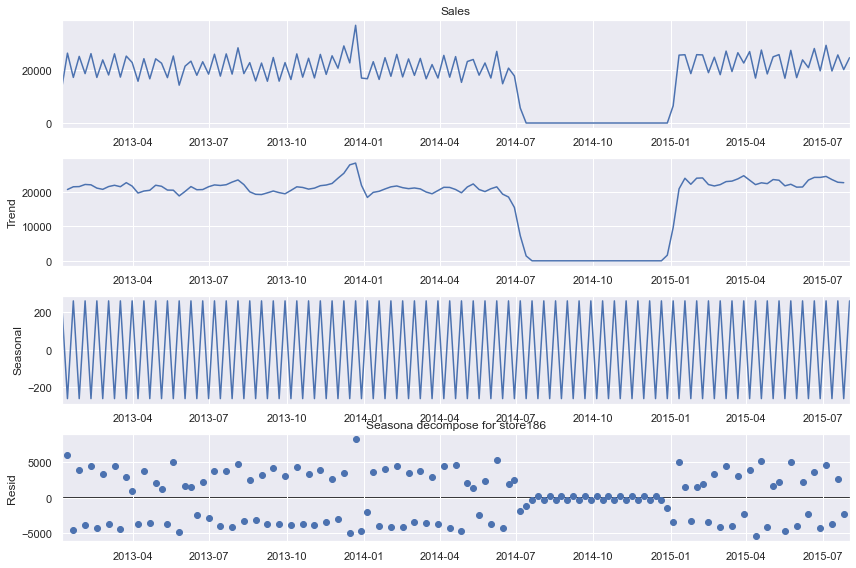

In [78]:
plt.rcParams['figure.figsize'] = (12, 8)
decomp = seasonal_decompose(storeweeklysales, model='additive', period=2)
decomp.plot()
plt.title(f'Seasona decompose for store{storeid}')
plt.show()

In [79]:
# check stationarity 
sta_result = adfuller(storeweeklysales)
print('ADF Statistic: %f' % sta_result[0])
print('p-value: %f' % sta_result[1])
print('Critical Values:')
for key, value in sta_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.713391
p-value: 0.424227
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.578


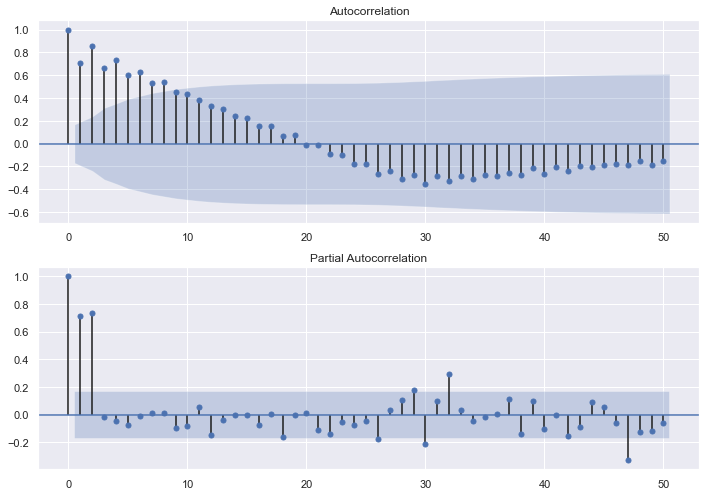

In [14]:
fig, ax = plt.subplots(2,1,figsize=(10,7))
plot_acf(storeweeklysales, lags=50, ax=ax[0])
# ax[0].axvline(12, color='red', ls='--', alpha=0.8, lw=0.7, label='lag = 12')
# ax[0].axvline(24, color='orange', ls='--', alpha=1, lw=0.8, label='lag = 24')
#ax[0].legend()
plot_pacf(storeweeklysales, lags=50, ax=ax[1])
plt.tight_layout()

## Try Mean Method

In [15]:

average = np.full((8,), storeweeklysales[:-9].mean()) # take the average value of  the train set as the predictions of the last 8 weeks 

true_values = storeweeklysales[-9:-1] # last 8 weeks actual sales
mae = mean_absolute_error(true_values, average)

#r2_score(true_values, average)


WAPE = np.sum(abs(average - true_values))/(df.set_index('Date').resample('w').Sales.sum()[-9:-1].sum())
           # last 8 weeks total sales for all store:  df.set_index('Date').resample('w').Sales.sum()[-9:-1].sum()
    
           
#print('R2 for average model: {0:.3f}'.format(r2_score(true_values, average)))
print('MAE for average method:{0:.1f}'.format(mae))
print('WAPE for mean method: {0:5f}'.format(WAPE)) 

MAE for average method:6428.3
WAPE for mean method: 0.000138


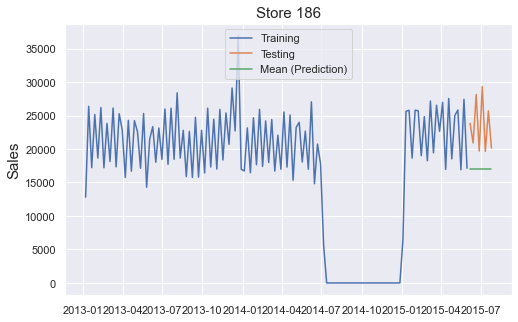

In [16]:
plt.plot(storeweeklysales[:-9],label="Training")
plt.plot(storeweeklysales[-9:-1],label="Testing")
#plt.plot(storeweeklysales, label='full')
#plt.plot(test,label="Test")
plt.plot(storeweeklysales[-9:-1].index, average, label="Mean (Prediction)")
plt.title(f'Store {storeid}', fontsize=15)
plt.ylabel('Sales', fontsize=15)
plt.legend(loc = 'upper center')
plt.show()

# Method 1: Use the whole data set to train model. 
1) When there's no zero value in the data set use the whole dataset to do train test split.

2) When there's zero value in the data set, drop it and use the non-zero value to do train test split. 

In [17]:
storeweeklysales = storeweeklysales[storeweeklysales!=0]

# when there's zero value, the data set will shrink, 
# when there's no zero value, data set will stay the same shape

In [18]:
# storeweeklysales.plot()
# plt.show()

In [19]:
train = storeweeklysales[:-9]
test = storeweeklysales[-9:-1]
print(f'The shape of storeweeklysales is {storeweeklysales.shape}')
print(f'Train set start from {train.index[0]} week,\nends at {train.index[-1]} week')
print(f'Test set start from {test.index[0]} week,\nends at {test.index[-1]} week')

The shape of storeweeklysales is (110,)
Train set start from 2013-01-06 00:00:00 week,
ends at 2015-05-31 00:00:00 week
Test set start from 2015-06-07 00:00:00 week,
ends at 2015-07-26 00:00:00 week


In [20]:
train.shape

(101,)

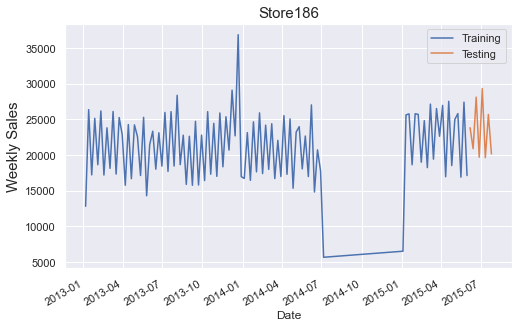

In [21]:
train.plot(label='Training')
test.plot(label='Testing')
plt.ylabel('Weekly Sales', fontsize=15)
plt.title(f'Store{storeid}',fontsize=15)
plt.legend()
plt.show()

## Auto Arima Model

In [22]:
# for store 262
warnings.filterwarnings("ignore")

arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=2, seasonal=True, 
                          error_action='warn',trace = False,
                          supress_warnings=True,stepwise = False,
                          random=True,
                          random_state=20, n_fits=50)

#predictions = pd.DataFrame(arima_model.predict(n_periods=8), index=test.index)


predictions = arima_model.predict(n_periods=8) # predicitons of last 8 weeks for store 262
true_values = test.values # last 8 weeks actual sales

mae = mean_absolute_error(true_values, predictions)
#R2 = r2_score(true_values, predictions)


WAPE = np.sum(abs(predictions - true_values))/(df.set_index('Date').resample('w').Sales.sum()[-9:-1].sum())
                # last 8 weeks total sales for all store:  df.set_index('Date').resample('w').Sales.sum()[-9:-1].sum()
    

#print('R2 for auto_arima model: {0:.3f}'.format(R2))
print('MAE for auto_arima model (method1): {0:.1f}'.format(mae)) 
print('WAPE for auto_arima model (method1): {0:.5f}'.format(WAPE)) 

MAE for auto_arima model (method1): 2124.9
WAPE for auto_arima model (method1): 0.00005


In [23]:
# create data index for forecasting value from week 2015-08-02 to week 2015-09-20

# testindex=storedailydata.set_index('Date').resample('w').Sales.sum()[-9:-1].index
# print(testindex)

forecastindex = pd.date_range('2015-07-27', '2015-09-20', freq='W')
print(forecastindex)

DatetimeIndex(['2015-08-02', '2015-08-09', '2015-08-16', '2015-08-23',
               '2015-08-30', '2015-09-06', '2015-09-13', '2015-09-20'],
              dtype='datetime64[ns]', freq='W-SUN')


In [24]:
arima_model = auto_arima(storeweeklysales[:test.index[-1]],start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=2, seasonal=True, 
                          error_action='warn',trace = False,
                          supress_warnings=True,stepwise = False,
                          random=True,
                          random_state=20, n_fits=50)


forecast, CI = arima_model.predict(n_periods=8, return_conf_int=True,alpha=0.05)

# forecast = pd.DataFrame(forecast, index=forecastindex)


In [25]:
pd.DataFrame([forecast, CI[:,0], CI[:,1]], index=['Forecast', 'lower CI', 'upper CI']).T.set_index(forecastindex)

,Forecast,lower CI,upper CI
2015-08-02,24457.885489,15053.213992,33862.556986
2015-08-09,21328.465140,11884.002242,30772.928039
2015-08-16,23671.829872,12955.498189,34388.161555
2015-08-23,21973.135194,11248.395902,32697.874486
2015-08-30,23266.716347,12115.470310,34417.962383
2015-09-06,22364.948771,11212.770965,33517.126577
2015-09-13,23069.322662,11754.434219,34384.211105
2015-09-20,22613.602270,11300.471787,33926.732754


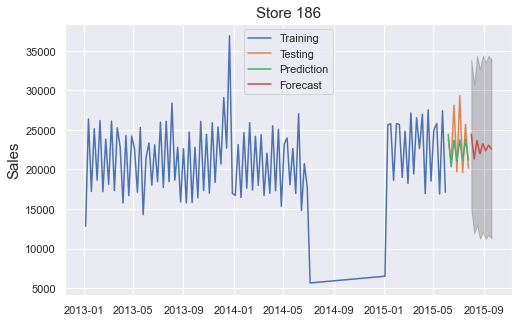

In [26]:
plt.plot(train,label="Training")
plt.plot(test,label="Testing")
#plt.plot(storeweeklysales, label='full')
#plt.plot(test,label="Test")
plt.plot(test.index, predictions, label="Prediction")
plt.plot(forecastindex, forecast,label="Forecast")
plt.fill_between(forecastindex, CI[:,0], CI[:,1]
                ,color='k', alpha=0.2)
plt.title(f'Store {storeid}', fontsize=15)
plt.ylabel('Sales', fontsize=15)
plt.legend(loc = 'upper center')
plt.show()

# Method 2: When there's continuing zero value in the data set, separate the data set to 2 parts with continuing zero value in between them, and use the second part to do train test split

In [27]:
storedailydata=df.loc[df.Store==storeid]
storeweeklysales = storedailydata.set_index('Date').resample('w').Sales.sum()

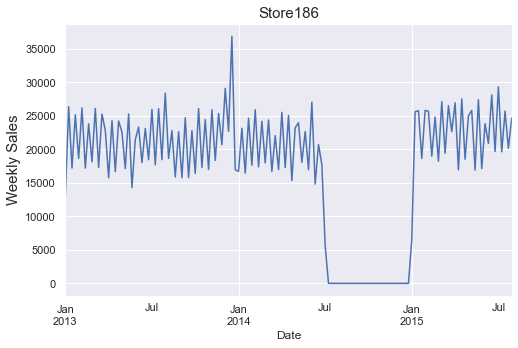

In [28]:
storeweeklysales.plot()
plt.title(f'Store{storeid}', fontsize=15)
plt.ylabel('Weekly Sales', fontsize=15)
plt.show()

In [29]:
from sys import exit

# if there's zero weekly sales in the data set, 
# filter out the index(week date) of the last week that has zero sales, 
# and our training set should start from the week after it
if len(storeweeklysales[(storeweeklysales == 0)].index) != 0 and len(storeweeklysales.loc[storeweeklysales[(storeweeklysales == 0)].index[-1]:].index)>=2:
    train_startdate = storeweeklysales.loc[storeweeklysales[(storeweeklysales == 0)].index[-1]:].index[1]


else:
    print('There is no zero value or no enough data after dropping the zero value in the data set')
    exit()

In [30]:
from sys import exit

if len(storeweeklysales.loc[train_startdate:][:-1]) >=16:
    train_enddate = len(storeweeklysales.loc[train_startdate:]) - 9
    train = storeweeklysales.loc[train_startdate:][:train_enddate]
    test = storeweeklysales[-9:-1]
    
else:
    print('Test set does not have enough datas')
    exit()
# if the training set is too short to do 8 weeks prediction (and forecasting) 
# then we will go back to the first methd which is use the whole data set and drop the zero values

In [31]:
print(f'Train set start from week {train.index[0]},\nends at week {train.index[-1]}')
print(f'Test set start from week {test.index[0]},\nends at week {test.index[-1]}')

Train set start from week 2015-01-04 00:00:00,
ends at week 2015-05-31 00:00:00
Test set start from week 2015-06-07 00:00:00,
ends at week 2015-07-26 00:00:00


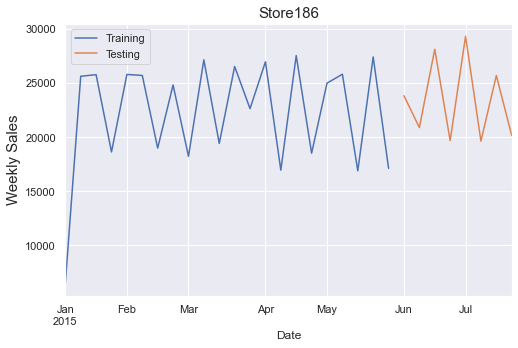

In [32]:
train.plot(label='Training')
test.plot(label='Testing')
plt.ylabel('Weekly Sales', fontsize=15)
plt.title(f'Store{storeid}',fontsize=15)
plt.legend()
plt.show()

In [33]:
forecastindex = pd.date_range('2015-07-27', '2015-09-20', freq='W')
forecastindex

DatetimeIndex(['2015-08-02', '2015-08-09', '2015-08-16', '2015-08-23',
               '2015-08-30', '2015-09-06', '2015-09-13', '2015-09-20'],
              dtype='datetime64[ns]', freq='W-SUN')

In [34]:
warnings.filterwarnings("ignore")
arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=2, seasonal=True, 
                          error_action='warn',trace = False,
                          supress_warnings=True,stepwise = False,
                          random=True,
                          random_state=20, n_fits=50)

predictions = arima_model.predict(n_periods=8)
#predictions_ci = arima_model.get_forecast(steps=7).conf_int()
true_values = test.values
mae = mean_absolute_error(true_values, predictions)
#R2 = r2_score(true_values, predictions)
WAPE = np.sum(abs(predictions - true_values))/(df.set_index('Date').resample('w').Sales.sum()[-9:-1].sum())
                # last 8 weeks total sales for all store:  df.set_index('Date').resample('w').Sales.sum()[-9:-1].sum()
    
#print('R2 for auto_arima model: {0:.3f}'.format(R2))
print('MAE for auto_arima model (method2): {0:.1f}'.format(mae))     
print('WAPE for auto_arima model (method2): {0:.5f}'.format(WAPE)) 

MAE for auto_arima model (method2): 1832.4
WAPE for auto_arima model (method2): 0.00004


In [35]:
arima_model = auto_arima(storeweeklysales.loc[train_startdate:test.index[-1]],start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=2, seasonal=True, 
                          error_action='warn',trace = False,
                          supress_warnings=True,stepwise = False,
                          random=True,
                          random_state=20, n_fits=50)


forecast, CI = arima_model.predict(n_periods=8, return_conf_int=True,alpha=0.05)
pd.DataFrame([forecast, CI[:,0], CI[:,1]], index=['Forecast', 'lower CI', 'upper CI']).T.set_index(forecastindex)

,Forecast,lower CI,upper CI
2015-08-02,26193.321429,16024.521203,36362.121654
2015-08-09,20653.321429,10484.521203,30822.121654
2015-08-16,26683.642857,12302.787665,41064.498049
2015-08-23,21143.642857,6762.787665,35524.498049
2015-08-30,27173.964286,9561.085643,44786.842929
2015-09-06,21633.964286,4021.085643,39246.842929
2015-09-13,27664.285714,7326.685263,48001.886166
2015-09-20,22124.285714,1786.685263,42461.886166


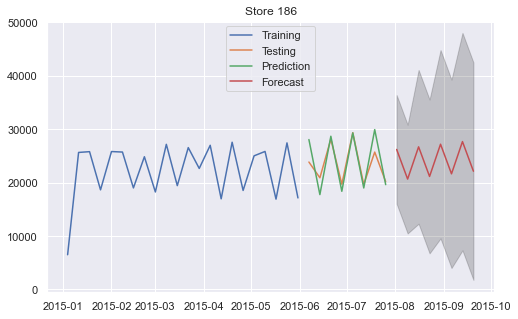

In [36]:
plt.plot(train,label="Training")
plt.plot(test,label="Testing")
#plt.plot(test,label="Test")
plt.plot(test.index, predictions, label="Prediction")
plt.plot(forecastindex, forecast,label="Forecast")
plt.fill_between(forecastindex, CI[:,0], CI[:,1]
                ,color='k', alpha=0.2)
plt.title(f'Store {storeid}')
plt.legend(loc = 'upper center')
plt.show()

Conclusion: 


MAE for average method:6428.3
<br>WAPE for mean method: 0.000138



MAE for auto_arima method 1 model: 2124.9
<br>WAPE for auto_arima method 1 model: 0.00005


MAE for auto_arima method 2 model: 1832.4
<br>WAPE for auto_arima method 2 model: 0.00004

<br> Therefore in this case, as auto arima method 2 generated better MAE and WAPE than method 1,  and ean method, so we wil use method 2 to do futrue forecasting for Store 186

## Process the steps above by importing class: modelingclass

In [37]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '/Users/liuyang/Desktop/Springboard_Capstone3/notebook')


In [38]:
from modeling_fixed_class import modeling

In [39]:
ndf = pd.read_csv('train.csv')
ndf.Date = pd.to_datetime(ndf.Date, format='%Y-%m-%d')

## Get Prediction Performance

In [40]:
modeling(ndf, 186).predict()

,Storeid,Prediction_AutoArima,Actual Value,Prediction_Average
Date,,,,
2015-06-07,186.0,28042.65,23839.0,16995.865079
2015-06-14,186.0,17748.65,20894.0,16995.865079
2015-06-21,186.0,28663.30,28129.0,16995.865079
2015-06-28,186.0,18369.30,19692.0,16995.865079
2015-07-05,186.0,29283.95,29330.0,16995.865079
2015-07-12,186.0,18989.95,19643.0,16995.865079
2015-07-19,186.0,29904.60,25703.0,16995.865079
2015-07-26,186.0,19610.60,20163.0,16995.865079


## Get Forecast

In [41]:
modeling(ndf, 186).forecast('2015-07-27', '2015-09-20')

,Forecast,lower CI,upper CI,Previous 8 Weeks
2015-08-02,26193.321429,16024.521203,36362.121654,23839.0
2015-08-09,20653.321429,10484.521203,30822.121654,20894.0
2015-08-16,26683.642857,12302.787665,41064.498049,28129.0
2015-08-23,21143.642857,6762.787665,35524.498049,19692.0
2015-08-30,27173.964286,9561.085643,44786.842929,29330.0
2015-09-06,21633.964286,4021.085643,39246.842929,19643.0
2015-09-13,27664.285714,7326.685263,48001.886166,25703.0
2015-09-20,22124.285714,1786.685263,42461.886166,20163.0


In [42]:
# ## Get Forecast Result

# webresult = modeling(ndf, 186).forecast('2015-07-27', '2015-09-20')

# webresult['Prediction'] = predictions
# webresult

# webresult.to_csv('Heroku_Sample_data_Store186.csv')

# pd.read_csv('Heroku_Sample_data_Store186.csv', index_col=[0])

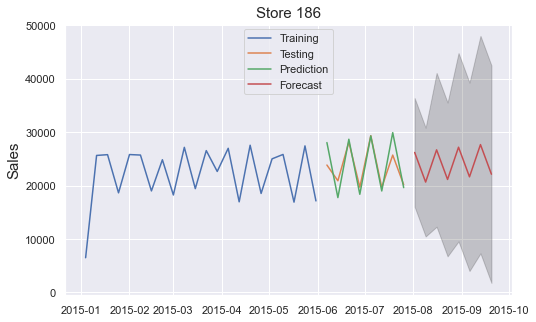

In [43]:
plt.plot(train,label="Training")
plt.plot(test,label="Testing")
#plt.plot(storeweeklysales, label='full')
#plt.plot(test,label="Test")
plt.plot(test.index, predictions, label="Prediction")
plt.plot(forecastindex, forecast,label="Forecast")
plt.fill_between(forecastindex, CI[:,0], CI[:,1]
                ,color='k', alpha=0.2)
plt.title(f'Store {storeid}', fontsize=15)
plt.ylabel('Sales', fontsize=15)
plt.legend(loc = 'upper center')
plt.show()

In [49]:
# # visualize the forecast plot

# fig = go.Figure([
#      go.Scatter(
#         name='Previous 8 Weeks',
#         x=storeweeklysales[-9:-1].index,
#         y=webresult['Previous 8 Weeks'],
#         mode='lines',
#         line=dict(color='rgb(31, 119, 180)'),
#     ),
#      go.Scatter(
#         hoverinfo='none',
#         name='',
#         x=[storeweeklysales[-9:-1].index[-1], webresult.index[0]],
#         y=[storeweeklysales[-9:-1].values[-1], webresult['Forecast'][0]], 
#         mode='lines',
#         line=dict(color='rgb(31, 119, 180)'),
#         showlegend=False
#     ),
#     go.Scatter(
#         name='Forcast',
#         x=webresult.index,
#         y=webresult['Forecast'],
#         mode='lines',
#         line=dict(color='rgb(255,0,0)'),
#     ),
#       go.Scatter(
#         name='Prediction for Previous  weeks',
#         x=storeweeklysales[-9:-1].index,
#         y=webresult['Prediction'],
#         mode='lines',
#         line=dict(color='rgb(0,255,0)'),
#     ),
#     go.Scatter(
#         name='Upper Bound',
#         x=webresult.index,
#         y=webresult['upper CI'],
#         mode='lines',
#         marker=dict(color="#444"),
#         line=dict(width=0),
#         showlegend=False
#     ),
#     go.Scatter(
#         name='Lower Bound',
#         x=webresult.index,
#         y=webresult['lower CI'],
#         marker=dict(color="#444"),
#         line=dict(width=0),
#         mode='lines',
#         fillcolor='rgba(68, 68, 68, 0.3)',
#         fill='tonexty',
#         showlegend=False
#     )
# ])
# fig.update_layout(
#     width=900,
#     height=500,
#     title=f'Store 909',
#     yaxis_title='Weekly Sales ',
#     hovermode="x"
# )
# fig.show()

In [ ]:
# modeling(ndf,186).predict()

In [ ]:
# modeling(ndf, 186).forecast('2015-07-27', '2015-09-20')

## Calculating WAPE

In [ ]:
# get_allstore = modeling(ndf,1).predict()

# for i in range(2,1116):
#     get_allstore=get_allstore.append(modeling(ndf, i).predict())

In [ ]:
# get_allstore.to_csv('prediction_actual_average.csv')

In [45]:
get_allstore = pd.read_csv('prediction_actual_average.csv', index_col=[0])
get_allstore

,Storeid,Prediction_AutoArima,Actual Value,Prediction_Average
Date,,,,
2015-06-07,1.0,26771.032822,26600.0,27663.309524
2015-06-14,1.0,23090.340364,23342.0,27663.309524
2015-06-21,1.0,26141.078580,27314.0,27663.309524
2015-06-28,1.0,23555.669168,21823.0,27663.309524
2015-07-05,1.0,25727.995588,31175.0,27663.309524
...,...,...,...,...
2015-06-28,1115.0,44259.328363,32956.0,36111.896825
2015-07-05,1115.0,44780.630471,48130.0,36111.896825
2015-07-12,1115.0,44593.255249,36233.0,36111.896825


## Plot WAPE

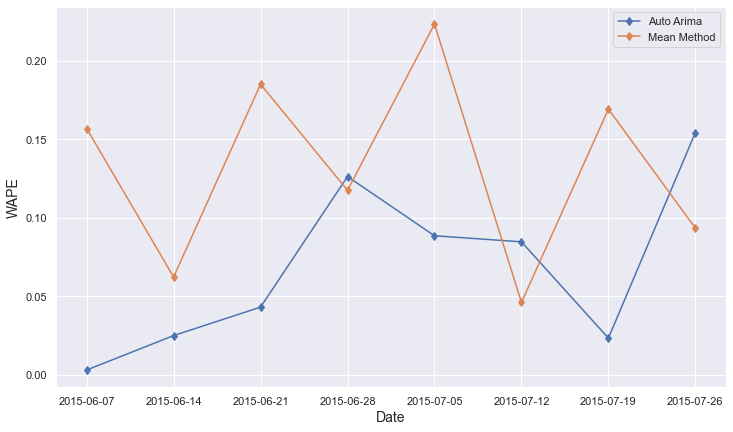

In [46]:
plt.rcParams['figure.figsize'] = (12, 7)
WAPE_autoarima = abs(get_allstore.groupby('Date')['Prediction_AutoArima'].sum()-
           get_allstore.groupby('Date')['Actual Value'].sum())/get_allstore.groupby('Date')['Actual Value'].sum()
WAPE_autoarima.plot(marker='d', label='Auto Arima')

WAPE_meanmethod = abs(get_allstore.groupby('Date')['Prediction_Average'].sum()-
           get_allstore.groupby('Date')['Actual Value'].sum())/get_allstore.groupby('Date')['Actual Value'].sum()
WAPE_meanmethod.plot(marker='d',label='Mean Method')
plt.xlabel('Date', fontsize=14)
plt.ylabel('WAPE', fontsize=14)
plt.legend()
plt.show()

In [80]:
WAPE_autoarima.mean()

0.06848040969993066

In [81]:
WAPE_meanmethod.mean()

0.13165461385909105

In [ ]:
# af.to_csv('prediction_actual_average.csv')

# paa = pd.read_csv('prediction_actual_average.csv')

# paa.rename(columns={'Unnamed: 0': 'Storeid'}, inplace =True)

# paa.set_index(test.index)

# ## Get prediction sum for each week

# predictions_week1 = []
# for i in range(1,4):
#         predictions_week1.append(af.loc[i][0:1]['Prediction_AutoArima'].values)


# actual_week1 = []
# for i in range(1,4):
#         actual_week1.append(af.loc[i][0:1]['Actual Value'].values)

# predictions_week2 = []
# for i in range(1,4):
#         predictions_week2.append(af.loc[i][1:2]['Prediction_AutoArima'].values)     

# actual_week2 = []
# for i in range(1,4):
#         actual_week2.append(af.loc[i][1:2]['Actual Value'].values)

# predictions_week3 = []
# for i in range(1,4):
#         predictions_week3.append(af.loc[i][2:3]['Prediction_AutoArima'].values)

# actual_week3 = []
# for i in range(1,4):
#         actual_week3.append(af.loc[i][2:3]['Actual Value'].values)

# predictions_week4 = []
# for i in range(1,4):
#         predictions_week4.append(af.loc[i][3:4]['Prediction_AutoArima'].values)

# actual_week4 = []
# for i in range(1,4):
#         actual_week4.append(af.loc[i][3:4]['Actual Value'].values)

# predictions_week5 = []
# for i in range(1,4):
#         predictions_week5.append(af.loc[i][4:5]['Prediction_AutoArima'].values)

# actual_week5 = []
# for i in range(1,4):
#         actual_week5.append(af.loc[i][4:5]['Actual Value'].values)

# predictions_week6 = []
# for i in range(1,4):
#         predictions_week6.append(af.loc[i][5:6]['Prediction_AutoArima'].values)

# actual_week6 = []
# for i in range(1,4):
#         actual_week6.append(af.loc[i][5:6]['Actual Value'].values)

# predictions_week7 = []
# for i in range(1,4):
#         predictions_week7.append(af.loc[i][6:7]['Prediction_AutoArima'].values)

# actual_week7 = []
# for i in range(1,4):
#         actual_week7.append(af.loc[i][6:7]['Actual Value'].values)

# predictions_week8 = []
# for i in range(1,4):
#         predictions_week8.append(af.loc[i][7:8]['Prediction_AutoArima'].values)

# actual_week8 = []
# for i in range(1,4):
#         actual_week8.append(af.loc[i][7:8]['Actual Value'].values)

# predictions_week1 = []
# for i in range(1,4):
#         predictions_week1.append(af.loc[i][0:1]['Prediction_AutoArima'].values)        

# ## Get average sum for each week

# average_week = []
# for i in range(1,4):
#     average_week.append(af.loc[i][1:2]['Prediction_Average'].values)

# average_weeksum= np.sum(average_week)

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")
# import numpy as np
# import pandas as pd
# from pmdarima.arima import auto_arima
# from sklearn.metrics import mean_absolute_error
# #from sklearn.metrics import r2_score


# class modeling:
#     warnings.I filterwarnings("ignore")

#     def __init__(self, data, storeid):
#         self.data = data
#         self.storeid = storeid
#         self.storeweeklysales = self.data.loc[self.data.Store == self.storeid].set_index('Date').resample('w').Sales.sum()
#         self.average = np.full((8,), self.storeweeklysales[:-9].mean())
#         self.mae = mean_absolute_error(self.storeweeklysales[-9:-1], self.average)
#         self.WAPE = np.sum(abs(self.average - self.storeweeklysales[-9:-1]))/(self.data.set_index('Date').resample('w').Sales.sum()[-9:-1].sum())
 
           
 

#     def predict(self):
#         #storeweeklysales = self.data.loc[self.data.Store == self.storeid].set_index('Date').resample('w').Sales.sum()
    
#         if len(self.storeweeklysales[(self.storeweeklysales == 0)].index) == 0:
#             train, test = (self.storeweeklysales[:-9], self.storeweeklysales[-9:-1])
#             arima_model = auto_arima(train, start_p=0, d=0, start_q=0,
#                                      max_p=5, max_d=5, max_q=5, start_P=0,
#                                      D=1, start_Q=0, max_P=5, max_D=5,
#                                      max_Q=5, m=2, seasonal=True,
#                                      error_action='warn', trace=False,
#                                      supress_warnings=True, stepwise=False,
#                                      random=True,
#                                      random_state=20, n_fits=50)

#             predictresult1 = arima_model.predict(n_periods=8)
#             true_values = test.values
#             mae = mean_absolute_error(true_values, predictresult1)
#             WAPE = np.sum(abs(predictresult1 - true_values))/(self.data.set_index('Date').resample('w').Sales.sum()[-9:-1].sum())
            
#             #R2 = r2_score(true_values, predictresult1)
#             return pd.DataFrame([mae, WAPE,  self.mae, self.WAPE], index=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'], columns=[self.storeid]).T
#             #return pd.DataFrame([mae, R2])

#         if len(self.storeweeklysales.loc[self.storeweeklysales[(self.storeweeklysales == 0)].index[-1]:].index)>=2 and len(self.storeweeklysales.loc[self.storeweeklysales.loc[self.storeweeklysales[(self.storeweeklysales == 0)].index[-1]:].index[1]:][:-1]) >= 16:
#             train_startdate = self.storeweeklysales.loc[self.storeweeklysales[(self.storeweeklysales == 0)].index[-1]:].index[1]
#             train_enddate = len(self.storeweeklysales.loc[train_startdate:]) - 9
#             train = self.storeweeklysales.loc[train_startdate:][:train_enddate]
#             #test = self.storeweeklysales.loc[train_startdate:][train_enddate:-1]
#             test = self.storeweeklysales[-9:-1]

#             arima_model = auto_arima(train, start_p=0, d=0,
#                                      start_q=0,
#                                      max_p=5, max_d=5, max_q=5, start_P=0,
#                                      D=1, start_Q=0, max_P=5, max_D=5,
#                                      max_Q=5, m=2, seasonal=True,
#                                      error_action='warn', trace=False,
#                                      supress_warnings=True, stepwise=False,
#                                      random=True,
#                                      random_state=20, n_fits=50)

#             predictresult = arima_model.predict(n_periods=8)
#             true_values = test.values
#             mae_2 = mean_absolute_error(true_values, predictresult)
#             WAPE_2 = np.sum(abs(predictresult - true_values))/(self.data.set_index('Date').resample('w').Sales.sum()[-9:-1].sum())
#             #R2_2 = r2_score(true_values, predictresult)
#             return pd.DataFrame([mae_2, WAPE_2, self. mae, self.WAPE], index=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod', 'WAPE_MeanMethod'], columns=[self.storeid]).T
#             #return pd.DataFrame([mae_2, R2_2])

#         else:
#             storeweeklysales_dropzero = self.storeweeklysales[self.storeweeklysales != 0]
#             train, test = (storeweeklysales_dropzero[:-9], storeweeklysales_dropzero[-9:-1])
#             arima_model = auto_arima(train, start_p=0, d=0, start_q=0,
#                                      max_p=5, max_d=5, max_q=5, start_P=0,
#                                      D=1, start_Q=0, max_P=5, max_D=5,
#                                      max_Q=5, m=2, seasonal=True,
#                                      error_action='warn', trace=False,
#                                      supress_warnings=True, stepwise=False,
#                                      random=True,
#                                      random_state=20, n_fits=50)

#             predictresult1 = arima_model.predict(n_periods=8)
#             true_values = test.values
#             mae = mean_absolute_error(true_values, predictresult1)
#             WAPE = np.sum(abs(predictresult1 - true_values))/(self.data.set_index('Date').resample('w').Sales.sum()[-9:-1].sum())
#             #R2 = r2_score(true_values, predictresult1)
#             return pd.DataFrame([mae, WAPE, self.mae, self.WAPE], index=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod', 'WAPE_MeanMethod' ], columns=[self.storeid]).T
#             #return pd.DataFrame([mae, R2])

#     def forecast(self, start_date, end_date):
#         # storeweeklysales = self.data.loc[self.data.Store == self.storeid].set_index('Date').resample('w').Sales.sum()
#         # storeweeklysales = storeweeklysales[storeweeklysales!=0]
#         forecastindex = pd.date_range(start_date, end_date, freq='W')
#         if len(self.storeweeklysales[(self.storeweeklysales == 0)].index) == 0:
#             train, test = (self.storeweeklysales[:-9], self.storeweeklysales[-9:-1])
#             arima_model = auto_arima(self.storeweeklysales[:test.index[-1]], start_p=0, d=0, start_q=0,
#                                      max_p=5, max_d=5, max_q=5, start_P=0,
#                                      D=1, start_Q=0, max_P=5, max_D=5,
#                                      max_Q=5, m=2, seasonal=True,
#                                      error_action='warn', trace=False,
#                                      supress_warnings=True, stepwise=False,
#                                      random=True,
#                                      random_state=20, n_fits=50)

#             forecast, CI = arima_model.predict(n_periods=8, return_conf_int=True, alpha=0.05)
#             forecastresult1 = pd.DataFrame([forecast, CI[:, 0], CI[:, 1]],
#                                            index=['Forecast', 'lower CI', 'upper CI']).T.set_index(forecastindex)
#             forecastresult1['Previous 8 Weeks'] = self.storeweeklysales[-9:-1].values
#             return forecastresult1

#         if len(self.storeweeklysales.loc[self.storeweeklysales[(self.storeweeklysales == 0)].index[-1]:].index)>=2 and len(self.storeweeklysales.loc[self.storeweeklysales.loc[self.storeweeklysales[(self.storeweeklysales == 0)].index[-1]:].index[1]:][:-1]) >= 16:
#             train_startdate = self.storeweeklysales.loc[self.storeweeklysales[(self.storeweeklysales == 0)].index[-1]:].index[1]
#             train_enddate = len(self.storeweeklysales.loc[train_startdate:]) - 9
#             train = self.storeweeklysales.loc[train_startdate:][:train_enddate]
#             #test = self.storeweeklysales.loc[train_startdate:][train_enddate:-1]
#             test = self.storeweeklysales[-9:-1]

#             arima_model = auto_arima(self.storeweeklysales.loc[train_startdate:test.index[-1]], start_p=0, d=0,
#                                      start_q=0,
#                                      max_p=5, max_d=5, max_q=5, start_P=0,
#                                      D=1, start_Q=0, max_P=5, max_D=5,
#                                      max_Q=5, m=2, seasonal=True,
#                                      error_action='warn', trace=False,
#                                      supress_warnings=True, stepwise=False,
#                                      random=True,
#                                      random_state=20, n_fits=50)

#             forecast, CI = arima_model.predict(n_periods=8, return_conf_int=True, alpha=0.05)
#             return pd.DataFrame([forecast, CI[:, 0], CI[:, 1], self.storeweeklysales[-9:-1].values],
#                                 index=['Forecast', 'lower CI', 'upper CI', 'Previous 8 Weeks']).T.set_index(forecastindex)


#         else:
#             storeweeklysales_dropzero = self.storeweeklysales[self.storeweeklysales != 0]
#             train, test = (storeweeklysales_dropzero[:-9], storeweeklysales_dropzero[-9:-1])
#             arima_model = auto_arima(storeweeklysales_dropzero[:test.index[-1]], start_p=0, d=0, start_q=0,
#                                      max_p=5, max_d=5, max_q=5, start_P=0,
#                                      D=1, start_Q=0, max_P=5, max_D=5,
#                                      max_Q=5, m=2, seasonal=True,
#                                      error_action='warn', trace=False,
#                                      supress_warnings=True, stepwise=False,
#                                      random=True,
#                                      random_state=20, n_fits=50)

#             forecast, CI = arima_model.predict(n_periods=8, return_conf_int=True, alpha=0.05)
#             forecastresult1 = pd.DataFrame([forecast, CI[:, 0], CI[:, 1]],
#                                            index=['Forecast', 'lower CI', 'upper CI']).T.set_index(forecastindex)

#             forecastresult1['Previous 8 Weeks'] = self.storeweeklysales[-9:-1].values
#             return forecastresult1

## Get MAE result for prediction for 1115 stores

In [ ]:
# model_eval_1_to_100 = []
# for i in range(1, 101):
#     model_eval_1_to_100 .append(modeling(ndf, i).predict().iloc[0,:].values)

# model_eval_101_to_200 = []
# for i in range(101, 201):
#     model_eval_101_to_200.append(modeling(ndf, i).predict().iloc[0,:].values)

# pd.DataFrame(np.array(model_eval_1_to_100), 
#              columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
#             ).to_csv('model_eval_1_to_100.csv', index=False)

# pd.DataFrame(np.array(model_eval_101_to_200), 
#              columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
#             ).to_csv('model_eval_101_to_200.csv', index=False)

# # pd.read_csv('model_eval_1_to_100.csv').loc[99]

# model_eval_201_to_300 = []
# for i in range(201, 301):
#     model_eval_201_to_300.append(modeling(ndf, i).predict().iloc[0,:].values)

# pd.DataFrame(np.array(model_eval_201_to_300), 
#              columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
#           ).to_csv('model_eval_201_to_300.csv', index=False)

# model_eval_301_to_400 = []
# for i in range(301, 401):
#     model_eval_301_to_400.append(modeling(ndf, i).predict().iloc[0,:].values)

# pd.DataFrame(np.array(model_eval_301_to_400), 
#              columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
#           ).to_csv('model_eval_301_to_400.csv', index=False)

# model_eval_401_to_500 = []
# for i in range(401, 501):
#     model_eval_401_to_500.append(modeling(ndf, i).predict().iloc[0,:].values)

# pd.DataFrame(np.array(model_eval_401_to_500), 
#              columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
#           ).to_csv('model_eval_401_to_500.csv', index=False)

# model_eval_501_to_600 = []
# for i in range(501, 601):
#     model_eval_501_to_600.append(modeling(ndf, i).predict().iloc[0,:].values)

# pd.DataFrame(np.array(model_eval_501_to_600), 
#              columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
#           ).to_csv('model_eval_501_to_600.csv', index=False)

# model_eval_601_to_700 = []
# for i in range(601, 701):
#     model_eval_601_to_700.append(modeling(ndf, i).predict().iloc[0,:].values)

# pd.DataFrame(np.array(model_eval_601_to_700), 
#              columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
#           ).to_csv('model_eval_601_to_700.csv', index=False)

# model_eval_701_to_800 = []
# for i in range(701, 801):
#     model_eval_701_to_800.append(modeling(ndf, i).predict().iloc[0,:].values)

# pd.DataFrame(np.array(model_eval_701_to_800), 
#              columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
#           ).to_csv('model_eval_701_to_800.csv', index=False)

# model_eval_801_to_900 = []
# for i in range(801, 901):
#     model_eval_801_to_900.append(modeling(ndf, i).predict().iloc[0,:].values)

# pd.DataFrame(np.array(model_eval_801_to_900), 
#              columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
#           ).to_csv('model_eval_801_to_900.csv', index=False)

# model_eval_901_to_1000 = []
# for i in range(901, 1001):
#     model_eval_901_to_1000.append(modeling(ndf, i).predict().iloc[0,:].values)

# pd.DataFrame(np.array(model_eval_901_to_1000), 
#              columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
#           ).to_csv('model_eval_901_to_1000.csv', index=False)

# model_eval_1001_to_1100 = []
# for i in range(1001, 1101):
#     model_eval_1001_to_1100.append(modeling(ndf, i).predict().iloc[0,:].values)

# pd.DataFrame(np.array(model_eval_1001_to_1100), 
#              columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
#           ).to_csv('model_eval_1001_to_1100.csv', index=False)

# model_eval_1101_to_1115= []
# for i in range(1101, 1116):
#     model_eval_1101_to_1115.append(modeling(ndf, i).predict().iloc[0,:].values)

# pd.DataFrame(np.array(model_eval_1101_to_1115), 
#              columns=['MAE_AutoArima', 'WAPE_AutoArima', 'MAE_MeanMethod','WAPE_MeanMethod'],
#           ).to_csv('model_eval_1101_to_1115.csv', index=False)

In [ ]:
#special store number 
# 292
# 876